# STEM images using different methods for extracting DFT potentials

In [33]:
%matplotlib inline
from __future__ import print_function
import collections
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from ase.io import read
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from pyqstem.potentials import poisson_solver,create_potential_slices
mpl.rc('font',**{'size' : 13})

In [34]:
epsilon0=0.07957747154594767 # permitivity of vacuum in atomic units
a0=0.52917721067 # bohr radius in angstrom
factor = 2/a0/epsilon0 # conversion factor between ASE units and QSTEM units

defocus = 0 # defocus [Angstrom]
v0 = 60 # acceleration voltage [keV]
alpha = 18 # convergence angle [mrad]

In [35]:
atoms=read('graphene.cif',index=0) # atomic configuration
tiled_atoms=atoms*(3,3,1)
cell=atoms.get_cell()
Lx,Ly,Lz=np.diag(cell)

qstem=PyQSTEM('STEM')
qstem.set_atoms(tiled_atoms)
scan_range=[[cell[0,0]*1,2*cell[0,0],30],
            [cell[1,1]*1,2*cell[1,1],30]]

## Potential directly from GPAW

These images are simulated using potentials calculated with GPAW's ps2ae module.

In [37]:
probes=[]
images=[]
spacings=[0.08,0.04,0.02]

for h in spacings:
    print(h)
    
    V=np.load('graphene_ae_potential_{0}.npy'.format(h)) # all-electron potential from GPAW using LDA
    
    Nx,Ny,Nz=V.shape
    res_x,res_y=Lx/Nx,Ly/Ny
    
    V_dft=create_potential_slices(V,10,(Lx,Ly,Lz)) # create projected potential slices
    V_dft.array=np.tile(V_dft.array,(3,3,1))
    
    V_dft.array/=-factor
    
    resolution = (res_x,res_y) # the resolution shoudl match the potential
    samples = (int(300*0.02/h),int(300*0.02/h)) # samples in x and y-direction
    
    qstem.build_probe(v0,alpha,samples,resolution=resolution,defocus=defocus)
    probes.append(qstem.get_wave())
    qstem.set_potential(V_dft,scan_range)
    
    qstem.add_detector('det1',(70,200))
    qstem.add_detector('det2',(0,70))
    
    qstem.run()
    
    images.append(qstem.read_detector('det1'))
    images.append(qstem.read_detector('det2'))

0.08
0.04
0.02


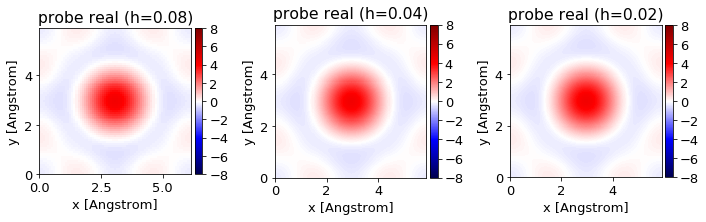

In [43]:
fig,axarr=plt.subplots(1,len(probes),figsize=(10,6))

if not isinstance(axarr,collections.Iterable):
    axarr=(axarr,)

for probe,ax,h in zip(probes,axarr,spacings):
    probe.view(method='real',ax=ax,title='probe real (h={0})'.format(h),
                cmap='seismic',vmin=-8,vmax=8)

plt.tight_layout()

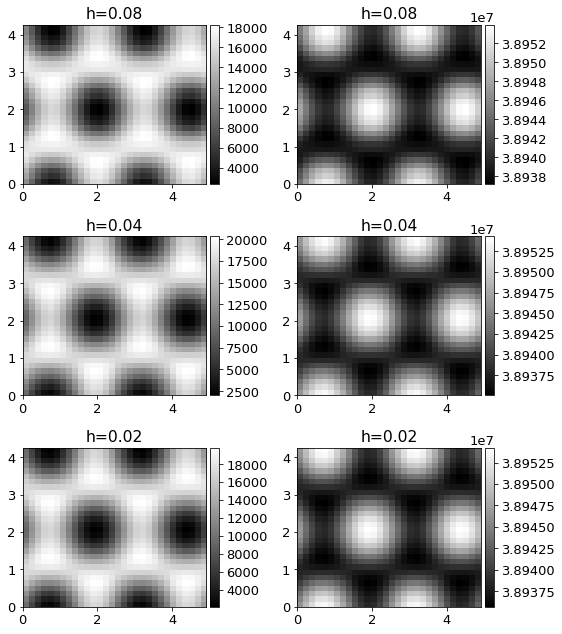

In [39]:
fig,axarr=plt.subplots(len(images)//2,2,figsize=(8,9))

extent=[0,scan_range[0][1]-scan_range[0][0],0,scan_range[1][1]-scan_range[1][0]]

axarr=axarr.flatten()

for i,(img,ax) in enumerate(zip(images,axarr)):
    
    ims=ax.imshow(img.T,extent=extent,interpolation='nearest',cmap='gray')
    ax.set_title('h={0}'.format(spacings[i//2]))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ims, cax=cax)
    
plt.tight_layout()

## Potential from charge distribution

These images are simulated using potentials calculated from a charge distribution.

In [7]:
images_charge=[]
spacings=[0.1,0.05]

for h in spacings:
    print(h)
    
    rho=np.load('graphene_ae_density_{0}.npy'.format(h)) # all-electron density from GPAW using LDA
    V=poisson_solver(rho,atoms,smooth=0,units='QSTEM')
    
    Nx,Ny,Nz=V.shape
    res_x,res_y=Lx/Nx,Ly/Ny
    
    V_dft=create_potential_slices(V,8,(Lx,Ly,Lz)) # create projected potential slices
    V_dft.array=np.tile(V_dft.array,(3,3,1))

    resolution = (res_x,res_y) # the resolution shoudl match the potential
    samples = (int(400*0.02/h),int(400*0.02/h)) # samples in x and y-direction
    
    qstem.build_probe(v0,alpha,samples,resolution=resolution,defocus=defocus)
    probes.append(qstem.get_wave())
    qstem.set_potential(V_dft,scan_range)
    
    qstem.add_detector('det1',(70,200))
    qstem.add_detector('det2',(0,70))
    
    qstem.run()
    
    images_charge.append(qstem.read_detector('det1'))
    images_charge.append(qstem.read_detector('det2'))

0.1
0.05


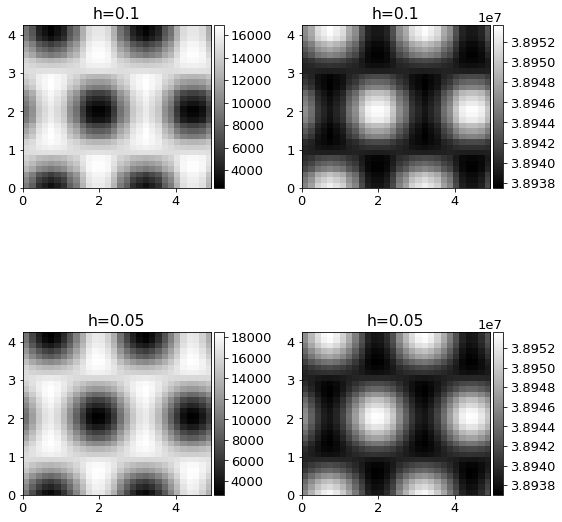

In [8]:
fig,axarr=plt.subplots(len(images_charge)//2,2,figsize=(8,9))

extent=[0,scan_range[0][1]-scan_range[0][0],0,scan_range[1][1]-scan_range[1][0]]

axarr=axarr.flatten()

for i,(img,ax) in enumerate(zip(images_charge,axarr)):
    
    ims=ax.imshow(img.T,extent=extent,interpolation='nearest',cmap='gray')
    ax.set_title('h={0}'.format(spacings[i//2]))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ims, cax=cax)
    
plt.tight_layout()

## Comparison

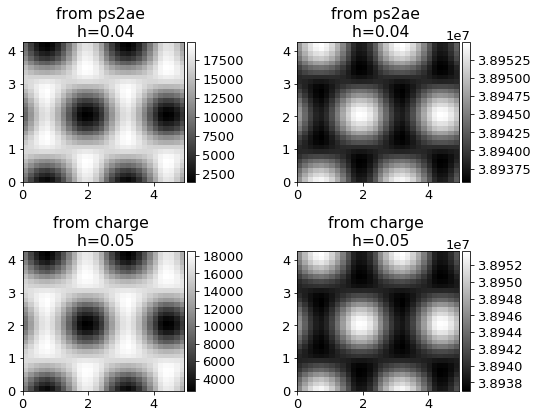

In [32]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(8,6))

ims=ax1.imshow(images[2].T,extent=extent,cmap='gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims, cax=cax)
ax1.set_title('from ps2ae \n h=0.04')

ims=ax2.imshow(images[3].T,extent=extent,cmap='gray')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims, cax=cax)
ax2.set_title('from ps2ae \n h=0.04')

ims=ax3.imshow(images_charge[2].T,extent=extent,cmap='gray')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims, cax=cax)
ax3.set_title('from charge \n h=0.05')

ims=ax4.imshow(images_charge[3].T,extent=extent,cmap='gray')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims, cax=cax)
ax4.set_title('from charge \n h=0.05')

plt.tight_layout()

